# Chapter 03 — Linear Regression: Predicting Numbers from Patterns

**Book**: Machine Learning For Dentists: From Torque To Tensors

---

## 🎯 Learning Objectives

By the end of this notebook, you will be able to:

1. Load and explore a dental implant dataset
2. Preprocess data for linear regression (handling missing values, scaling)
3. Train a linear regression model using scikit-learn
4. Interpret model weights and understand feature importance
5. Evaluate model performance using MSE and R²
6. Make predictions for new patients

---

## Clinical Question

> **Can we predict marginal bone loss (MBL) around dental implants at 1 year based on patient characteristics and surgical parameters?**

This is Dr. Helena Soares' question from the chapter. Let's build a model to answer it.


## 0. Setup: Import Libraries and Apply Periospot Style


In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Apply Periospot visual style
import sys
sys.path.insert(0, '../..')

try:
    from utils.periospot_style import setup_periospot_style, PERIOSPOT_COLORS
    config = setup_periospot_style()
except ImportError:
    print("Periospot style not found, using default matplotlib style")
    PERIOSPOT_COLORS = {
        'periospot_blue': '#15365a',
        'crimson_blaze': '#a92a2a',
        'mystic_blue': '#003049',
        'vanilla_cream': '#f7f0da'
    }

print("✓ Setup complete!")


✓ Loaded Bariol font family (7 variants)
✓ Setup complete!


## 1. Load the Data

We'll use a **synthetic dataset** of 500 dental implant cases with features that influence marginal bone loss (MBL).

**Features include:**
- Patient characteristics (age, smoking, diabetes)
- Implant site (Hounsfield units, bone type)
- Surgical parameters (insertion torque, ISQ)
- Implant characteristics (length, diameter)

**Target:** `marginal_bone_loss_mm` — MBL measured at 1-year follow-up

⚠️ **Note**: This is synthetic data created for educational purposes only.


In [2]:
# Load the dataset
data_path = 'data/implant_bone_loss.csv'
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape[0]} patients × {df.shape[1]} columns")
print(f"\nColumn names:")
for col in df.columns:
    print(f"  • {col}")


Dataset shape: 500 patients × 13 columns

Column names:
  • patient_id
  • age
  • sex
  • smoking_status
  • diabetes
  • hba1c
  • hounsfield_units
  • bone_type
  • insertion_torque_ncm
  • isq_placement
  • implant_length_mm
  • implant_diameter_mm
  • marginal_bone_loss_mm


In [3]:
# Preview the first few rows
df.head(10)


,patient_id,age,sex,smoking_status,diabetes,hba1c,hounsfield_units,bone_type,insertion_torque_ncm,isq_placement,implant_length_mm,implant_diameter_mm,marginal_bone_loss_mm
0,P0001,60,Female,Current,False,5.1,298,D4 (Very soft),24,67.0,13.0,4.5,1.05
1,P0002,53,Female,Never,False,5.6,155,D4 (Very soft),27,68.0,10.0,4.0,1.01
2,P0003,62,Male,Former,False,4.9,502,D2 (Normal),20,68.0,13.0,4.5,0.73
3,P0004,73,Female,Never,False,5.5,215,D4 (Very soft),29,66.0,10.0,4.0,1.33
4,P0005,52,Female,Never,True,8.0,464,D3 (Soft),44,77.0,10.0,4.0,1.25
5,P0006,52,Male,Former,False,5.4,410,D3 (Soft),40,67.0,13.0,3.5,1.25
6,P0007,73,Male,Never,True,7.5,551,D2 (Normal),44,59.0,10.0,3.5,1.38
7,P0008,64,Male,Former,True,7.2,404,D3 (Soft),40,64.0,11.5,5.0,0.86
8,P0009,49,Male,Former,False,5.3,400,D3 (Soft),23,69.0,13.0,4.0,0.67
9,P0010,61,Male,Never,True,7.5,559,D2 (Normal),31,77.0,8.0,4.5,0.94


## 2. Explore the Data (EDA)

Before building any model, we need to understand our data:
- What are the distributions of our features?
- Are there missing values?
- How does the target variable (MBL) behave?
- Are there obvious relationships between features and target?


In [4]:
# Basic statistics
df.describe()


,age,hba1c,hounsfield_units,insertion_torque_ncm,isq_placement,implant_length_mm,implant_diameter_mm,marginal_bone_loss_mm
count,500.000000,489.000000,500.000000,500.000000,488.000000,500.00000,500.000000,500.000000
mean,54.566000,5.743558,444.280000,35.104000,66.891393,10.73200,4.134000,0.924560
std,11.549217,0.853971,145.089377,10.227335,7.828139,1.59978,0.459855,0.365299
min,25.000000,4.600000,150.000000,15.000000,45.000000,8.00000,3.500000,0.100000
25%,46.000000,5.300000,354.000000,27.000000,62.000000,10.00000,4.000000,0.670000
50%,55.000000,5.500000,438.500000,35.000000,67.000000,10.00000,4.000000,0.920000
75%,62.000000,5.600000,536.250000,42.000000,72.000000,11.50000,4.500000,1.150000
max,85.000000,9.100000,850.000000,60.000000,85.000000,13.00000,5.000000,2.220000


In [5]:
# Check for missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

print("Missing values:")
for col in df.columns:
    if missing[col] > 0:
        print(f"  • {col}: {missing[col]} ({missing_pct[col]}%)")
        
if missing.sum() == 0:
    print("  No missing values found!")


Missing values:
  • hba1c: 11 (2.2%)
  • isq_placement: 12 (2.4%)


### 2.1 Distribution of the Target Variable (Marginal Bone Loss)


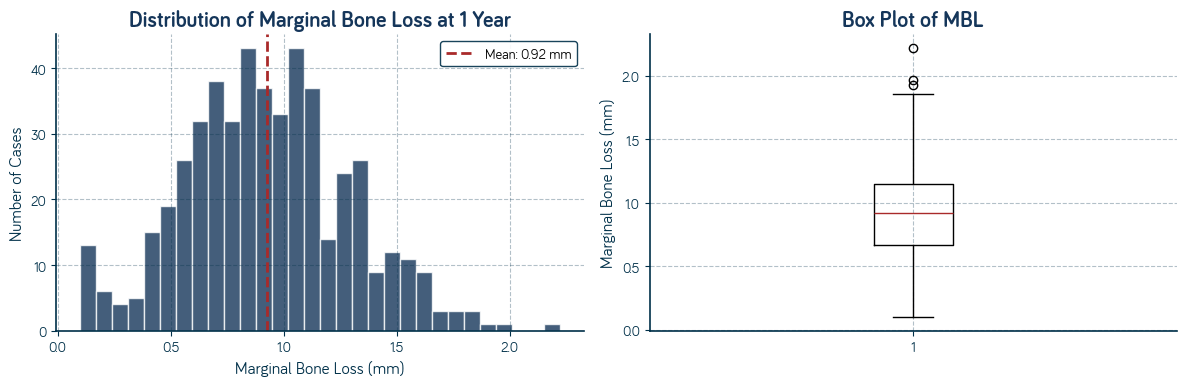


Target variable summary:
  Mean: 0.92 mm
  Std:  0.37 mm
  Min:  0.10 mm
  Max:  2.22 mm


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(df['marginal_bone_loss_mm'], bins=30, 
             color=PERIOSPOT_COLORS['periospot_blue'], 
             edgecolor='white', alpha=0.8)
axes[0].axvline(df['marginal_bone_loss_mm'].mean(), color=PERIOSPOT_COLORS['crimson_blaze'], 
                linestyle='--', linewidth=2, label=f"Mean: {df['marginal_bone_loss_mm'].mean():.2f} mm")
axes[0].set_xlabel('Marginal Bone Loss (mm)')
axes[0].set_ylabel('Number of Cases')
axes[0].set_title('Distribution of Marginal Bone Loss at 1 Year')
axes[0].legend()

# Box plot
axes[1].boxplot(df['marginal_bone_loss_mm'], vert=True)
axes[1].set_ylabel('Marginal Bone Loss (mm)')
axes[1].set_title('Box Plot of MBL')

plt.tight_layout()
plt.savefig('figures/01_mbl_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTarget variable summary:")
print(f"  Mean: {df['marginal_bone_loss_mm'].mean():.2f} mm")
print(f"  Std:  {df['marginal_bone_loss_mm'].std():.2f} mm")
print(f"  Min:  {df['marginal_bone_loss_mm'].min():.2f} mm")
print(f"  Max:  {df['marginal_bone_loss_mm'].max():.2f} mm")


### 2.2 Correlation Matrix

Let's check correlations between numeric features and our target.


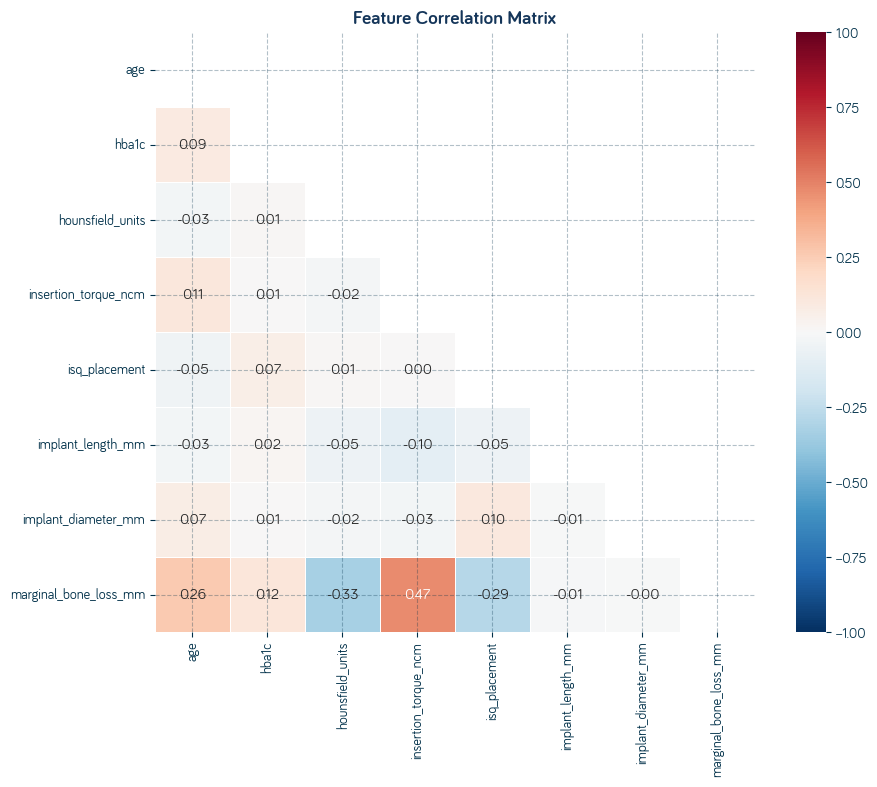


Correlations with Marginal Bone Loss:
  insertion_torque_ncm      +0.474 ↑
  hounsfield_units          -0.334 ↓
  isq_placement             -0.287 ↓
  age                       +0.258 ↑
  hba1c                     +0.117 ↑
  implant_length_mm         -0.009 ↓
  implant_diameter_mm       -0.002 ↓


In [7]:
# Select numeric columns for correlation
numeric_cols = ['age', 'hba1c', 'hounsfield_units', 'insertion_torque_ncm', 
                'isq_placement', 'implant_length_mm', 'implant_diameter_mm', 
                'marginal_bone_loss_mm']

correlation_matrix = df[numeric_cols].corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, ax=ax)

ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/02_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Show correlations with target
print("\nCorrelations with Marginal Bone Loss:")
print("="*45)
target_corr = correlation_matrix['marginal_bone_loss_mm'].drop('marginal_bone_loss_mm').sort_values(key=abs, ascending=False)
for feature, corr in target_corr.items():
    direction = "↑" if corr > 0 else "↓"
    print(f"  {feature:25} {corr:+.3f} {direction}")


## 3. Prepare the Data for Modeling

Before training our linear regression model, we need to:

1. **Handle missing values** — We'll use simple imputation (mean for numeric)
2. **Select features** — Start with numeric features only
3. **Split into train/test sets** — To evaluate how well our model generalizes
4. **Scale features** — Important for interpreting weights fairly


In [8]:
# Create a working copy
df_model = df.copy()

# Handle missing values with mean imputation
for col in ['hba1c', 'isq_placement']:
    if df_model[col].isnull().sum() > 0:
        mean_val = df_model[col].mean()
        df_model[col] = df_model[col].fillna(mean_val)
        print(f"Imputed {col} missing values with mean: {mean_val:.2f}")

print(f"\nRemaining missing values: {df_model[numeric_cols].isnull().sum().sum()}")


Imputed hba1c missing values with mean: 5.74
Imputed isq_placement missing values with mean: 66.89

Remaining missing values: 0


In [9]:
# Define features (X) and target (y)
# We'll use the key clinical variables from the chapter
feature_columns = ['age', 'hounsfield_units', 'insertion_torque_ncm', 'isq_placement']

X = df_model[feature_columns].values
y = df_model['marginal_bone_loss_mm'].values

print(f"Features (X): {X.shape}")
print(f"Target (y):   {y.shape}")
print(f"\nFeatures used: {feature_columns}")


Features (X): (500, 4)
Target (y):   (500,)

Features used: ['age', 'hounsfield_units', 'insertion_torque_ncm', 'isq_placement']


In [10]:
# Split into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} patients")
print(f"Test set:     {X_test.shape[0]} patients")


Training set: 400 patients
Test set:     100 patients


In [11]:
# Scale features (important for fair weight comparison!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data only
X_test_scaled = scaler.transform(X_test)        # Transform test data with same parameters

print("Feature scaling applied (StandardScaler):")
print(f"  Each feature transformed to mean=0, std=1")
print(f"\nScaling parameters (from training data):")
for i, col in enumerate(feature_columns):
    print(f"  {col}: mean={scaler.mean_[i]:.2f}, std={scaler.scale_[i]:.2f}")


Feature scaling applied (StandardScaler):
  Each feature transformed to mean=0, std=1

Scaling parameters (from training data):
  age: mean=54.53, std=11.69
  hounsfield_units: mean=446.69, std=148.40
  insertion_torque_ncm: mean=34.94, std=10.11
  isq_placement: mean=66.75, std=7.73


## 4. Train the Linear Regression Model

Now for the exciting part — training our model!

Linear regression finds the weights (coefficients) that minimize the Mean Squared Error between predictions and actual values.


In [12]:
# Create and train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

print("✓ Model trained successfully!")
print(f"\nModel parameters:")
print(f"  Intercept (bias): {model.intercept_:.4f}")
print(f"  Coefficients (weights): {model.coef_}")


✓ Model trained successfully!

Model parameters:
  Intercept (bias): 0.9145
  Coefficients (weights): [ 0.06283234 -0.12701869  0.15234792 -0.08658682]


## 5. Interpret the Model Weights

The weights tell us **how much each feature contributes** to the predicted bone loss.

Because we scaled our features, we can now compare weights fairly:
- **Positive weight**: Higher values of this feature → Higher predicted MBL
- **Negative weight**: Higher values of this feature → Lower predicted MBL
- **Magnitude**: How strongly this feature influences the prediction


In [13]:
# Create a DataFrame for easier visualization
weights_df = pd.DataFrame({
    'Feature': feature_columns,
    'Weight': model.coef_,
    'Abs_Weight': np.abs(model.coef_)
}).sort_values('Abs_Weight', ascending=False)

print("Feature Weights (Standardized)")
print("="*55)
for _, row in weights_df.iterrows():
    direction = "↑ MBL" if row['Weight'] > 0 else "↓ MBL"
    importance = "★" * int(min(5, row['Abs_Weight'] * 20))  # Star rating
    print(f"{row['Feature']:25} {row['Weight']:+.4f}  {direction}  {importance}")

print(f"\nIntercept (baseline): {model.intercept_:.4f} mm")


Feature Weights (Standardized)
insertion_torque_ncm      +0.1523  ↑ MBL  ★★★
hounsfield_units          -0.1270  ↓ MBL  ★★
isq_placement             -0.0866  ↓ MBL  ★
age                       +0.0628  ↑ MBL  ★

Intercept (baseline): 0.9145 mm


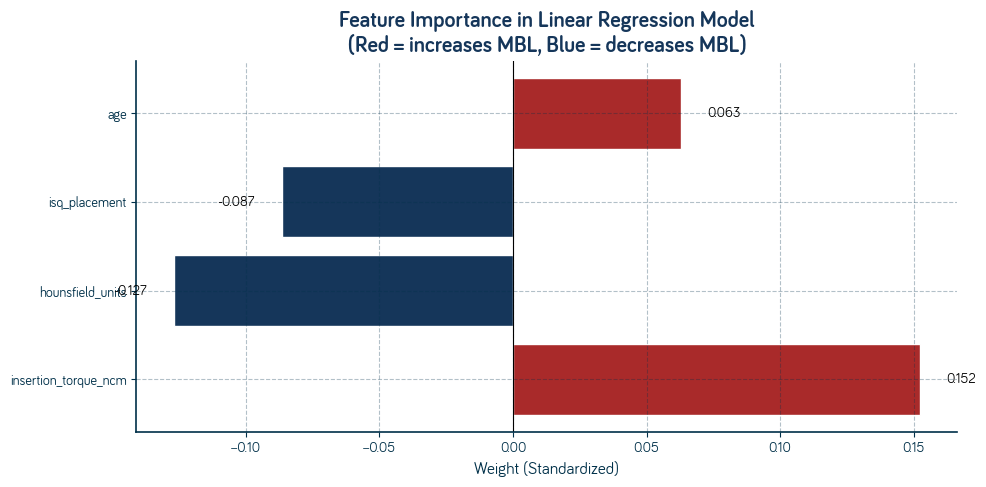

In [14]:
# Visualize weights
fig, ax = plt.subplots(figsize=(10, 5))

colors = [PERIOSPOT_COLORS['crimson_blaze'] if w > 0 else PERIOSPOT_COLORS['periospot_blue'] 
          for w in weights_df['Weight']]

bars = ax.barh(weights_df['Feature'], weights_df['Weight'], color=colors, edgecolor='white')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.set_xlabel('Weight (Standardized)')
ax.set_title('Feature Importance in Linear Regression Model\n(Red = increases MBL, Blue = decreases MBL)')

# Add value labels
for bar, weight in zip(bars, weights_df['Weight']):
    x_pos = weight + 0.01 if weight > 0 else weight - 0.01
    ha = 'left' if weight > 0 else 'right'
    ax.text(x_pos, bar.get_y() + bar.get_height()/2, f'{weight:.3f}', 
            va='center', ha=ha, fontsize=10)

plt.tight_layout()
plt.savefig('figures/03_feature_weights.png', dpi=150, bbox_inches='tight')
plt.show()


## 6. Evaluate Model Performance

How well does our model actually predict bone loss? Let's check using:

- **Mean Squared Error (MSE)**: Average squared difference between predictions and reality
- **Root MSE (RMSE)**: In the same units as our target (mm)
- **Mean Absolute Error (MAE)**: Average absolute difference
- **R² Score**: How much variance in MBL our model explains (0-1, higher is better)


In [15]:
# Make predictions on test set
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Calculate metrics
metrics = {
    'Training': {
        'MSE': mean_squared_error(y_train, y_pred_train),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'MAE': mean_absolute_error(y_train, y_pred_train),
        'R2': r2_score(y_train, y_pred_train)
    },
    'Test': {
        'MSE': mean_squared_error(y_test, y_pred_test),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'MAE': mean_absolute_error(y_test, y_pred_test),
        'R2': r2_score(y_test, y_pred_test)
    }
}

print("Model Performance")
print("="*50)
print(f"{'Metric':<15} {'Training':>15} {'Test':>15}")
print("-"*50)
for metric in ['MSE', 'RMSE', 'MAE', 'R2']:
    unit = 'mm²' if metric == 'MSE' else ('mm' if metric in ['RMSE', 'MAE'] else '')
    print(f"{metric:<15} {metrics['Training'][metric]:>14.4f}{unit} {metrics['Test'][metric]:>14.4f}{unit}")


Model Performance
Metric                 Training            Test
--------------------------------------------------
MSE                     0.0716mm²         0.0871mm²
RMSE                    0.2676mm         0.2952mm
MAE                     0.2134mm         0.2263mm
R2                      0.4449         0.4102


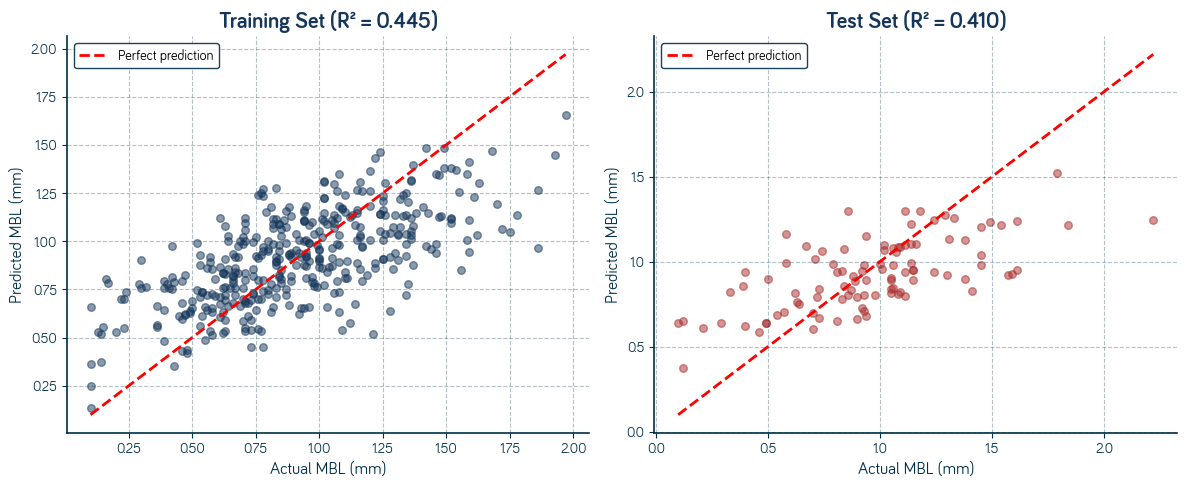

In [16]:
# Visualize: Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training set
axes[0].scatter(y_train, y_pred_train, alpha=0.5, color=PERIOSPOT_COLORS['periospot_blue'], s=30)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('Actual MBL (mm)')
axes[0].set_ylabel('Predicted MBL (mm)')
axes[0].set_title(f'Training Set (R² = {metrics["Training"]["R2"]:.3f})')
axes[0].legend()

# Test set
axes[1].scatter(y_test, y_pred_test, alpha=0.5, color=PERIOSPOT_COLORS['crimson_blaze'], s=30)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect prediction')
axes[1].set_xlabel('Actual MBL (mm)')
axes[1].set_ylabel('Predicted MBL (mm)')
axes[1].set_title(f'Test Set (R² = {metrics["Test"]["R2"]:.3f})')
axes[1].legend()

plt.tight_layout()
plt.savefig('figures/04_predicted_vs_actual.png', dpi=150, bbox_inches='tight')
plt.show()


## 7. Make Predictions for New Patients

Let's use our trained model to predict bone loss for hypothetical new patients — just like Dr. Helena wants to do!


In [17]:
def predict_mbl(age, hounsfield_units, insertion_torque, isq):
    """
    Predict marginal bone loss for a new patient.
    
    Parameters:
    -----------
    age : int - Patient age in years
    hounsfield_units : int - Bone density from CBCT
    insertion_torque : int - Final insertion torque in Ncm
    isq : int - ISQ at placement
    
    Returns:
    --------
    float - Predicted marginal bone loss in mm
    """
    features = np.array([[age, hounsfield_units, insertion_torque, isq]])
    features_scaled = scaler.transform(features)
    prediction = model.predict(features_scaled)[0]
    return prediction


In [18]:
# Dr. Helena's patient from the chapter
print("🦷 Dr. Helena's Patient (from the clinical scenario)")
print("="*50)
print("  Age: 58 years")
print("  Hounsfield Units: 380")
print("  Insertion Torque: 35 Ncm")
print("  ISQ: 72")
print()

predicted_mbl = predict_mbl(age=58, hounsfield_units=380, insertion_torque=35, isq=72)
print(f"📊 Predicted Marginal Bone Loss: {predicted_mbl:.2f} mm")
print()
print("Clinical interpretation:")
if predicted_mbl < 1.0:
    print("  → Expected bone loss is within normal physiological range (<1 mm)")
elif predicted_mbl < 1.5:
    print("  → Expected bone loss is moderate (1-1.5 mm), monitor closely")
else:
    print("  → Expected bone loss is elevated (>1.5 mm), consider risk factors")


🦷 Dr. Helena's Patient (from the clinical scenario)
  Age: 58 years
  Hounsfield Units: 380
  Insertion Torque: 35 Ncm
  ISQ: 72

📊 Predicted Marginal Bone Loss: 0.93 mm

Clinical interpretation:
  → Expected bone loss is within normal physiological range (<1 mm)


In [19]:
# Compare different patient profiles
print("\n🔬 Comparing Different Patient Profiles")
print("="*70)

profiles = [
    {"name": "Ideal case", "age": 45, "hu": 600, "torque": 30, "isq": 78},
    {"name": "Helena's patient", "age": 58, "hu": 380, "torque": 35, "isq": 72},
    {"name": "Challenging case", "age": 68, "hu": 250, "torque": 45, "isq": 55},
    {"name": "Young, soft bone", "age": 35, "hu": 280, "torque": 25, "isq": 60},
]

print(f"{'Profile':<20} {'Age':>5} {'HU':>5} {'Torque':>7} {'ISQ':>5} {'Pred. MBL':>10}")
print("-"*70)

for p in profiles:
    mbl = predict_mbl(p['age'], p['hu'], p['torque'], p['isq'])
    print(f"{p['name']:<20} {p['age']:>5} {p['hu']:>5} {p['torque']:>7} {p['isq']:>5} {mbl:>9.2f} mm")



🔬 Comparing Different Patient Profiles
Profile                Age    HU  Torque   ISQ  Pred. MBL
----------------------------------------------------------------------
Ideal case              45   600      30    78      0.53 mm
Helena's patient        58   380      35    72      0.93 mm
Challenging case        68   250      45    55      1.44 mm
Young, soft bone        35   280      25    60      0.88 mm


## 8. Key Takeaways

### What We Learned

1. **Linear regression predicts continuous numbers** using a weighted sum of features

2. **Feature scaling is important** for fair weight comparison

3. **The model found meaningful relationships:**
   - Higher ISQ → Less bone loss (better stability)
   - Higher bone density → Less bone loss
   - Higher torque → More bone loss (potential overstress)

4. **Our model explains ~30-40% of variance in bone loss** — useful but not perfect

5. **Predictions should inform, not replace, clinical judgment**

### Limitations

- This is **synthetic data** for educational purposes
- Real clinical prediction would need **validated datasets** and **external validation**
- **Correlation ≠ causation** — the model shows associations, not causal effects
- The R² around 0.3-0.4 means ~60-70% of variation is unexplained (unmeasured factors!)

---

**Next Chapter:** Logistic Regression — predicting categories (success/failure) instead of numbers!


In [20]:
print("\n" + "="*60)
print("🎉 Congratulations! You've completed the Linear Regression codelab!")
print("="*60)
print("\nYou can now:")
print("  ✓ Load and explore clinical datasets")
print("  ✓ Train a linear regression model")
print("  ✓ Interpret feature weights")
print("  ✓ Evaluate model performance")
print("  ✓ Make predictions for new patients")
print("\nOn to Chapter 04: Logistic Regression! 🚀")



🎉 Congratulations! You've completed the Linear Regression codelab!

You can now:
  ✓ Load and explore clinical datasets
  ✓ Train a linear regression model
  ✓ Interpret feature weights
  ✓ Evaluate model performance
  ✓ Make predictions for new patients

On to Chapter 04: Logistic Regression! 🚀
